## Importing libraries

In [1]:
import msgpack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

from geexhp.pypsg import PSG
from geexhp.core import datamod, datavis, geostages
datavis.configure_matplotlib()

## First Test - Loading HWO configuration file for Modern Earth

In [2]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

In [3]:
molecules = config["ATMOSPHERE-LAYERS-MOLECULES"].split(',')
pressures = []
temperatures = []
concentration_dict = {mol: [] for mol in molecules}

for i in range(60):
    layer = config.get(f"ATMOSPHERE-LAYER-{i + 1}").split(',')
    pressure = float(layer[0])
    temperature = float(layer[1])
    concentrations = [float(value) for value in layer[2:]]
    
    pressures.append(pressure)
    temperatures.append(temperature)
    for j, mol in enumerate(molecules):
        concentration_dict[mol].append(concentrations[j])

data = {
    "Pressure": pressures,
    "Temperature": temperatures
}
data.update(concentration_dict)
mixing_ratio = pd.DataFrame(data)

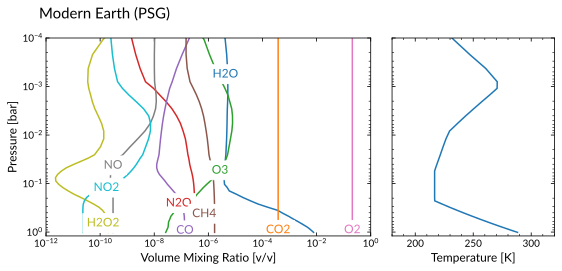

In [4]:
molecules = ["H2O", "CO2", "O3", "N2O", "CO", "CH4", "O2", "NO", "H2O2", "NO2"]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1.5]}, sharey=True)
for molecule in molecules:
    line, = ax[0].plot(mixing_ratio[molecule], mixing_ratio["Pressure"], label=molecule)
    if molecule in ["H2O2", "O3", "CO"]:
        x_pos = np.quantile(line.get_xdata(), q=0.75)
    else:
        x_pos = np.median(line.get_xdata())
    datavis.label_line(line, x=x_pos, label=molecule, align=False)
    
ax[0].invert_yaxis()
ax[0].axis([1e-12, 1, 1.2, 1e-4])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Volume Mixing Ratio [v/v]", ylabel="Pressure [bar]")

mixing_ratio.plot(x="Temperature", y="Pressure", ax=ax[1], legend=False)
ax[1].invert_yaxis()
ax[1].axis([180, 320, 1.2, 1e-4])
ax[1].set(xlabel="Temperature [K]", ylabel="")
ax[1].set_yscale("log")

fig.suptitle("Modern Earth (PSG)", x=0.08, y=0.95, horizontalalignment='left', 
                verticalalignment='top', fontsize=15)
plt.tight_layout();

In [3]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [4]:
config_HWC = config.copy()
geostages.modern_earth(config_HWC)
datamod.set_instrument(config_HWC, 'HWC')
result = psg.run(config_HWC)

In [7]:
print(result["header"])

# WARNING | PUMAS | Some species, CH3Cl, do not have optimized correlated-k tables for the defined moderate resolutions, and will be analyzed at sub-par resolutions. In particular, there will be issues at the line cores.
# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Sun Jun 30 18:30:20 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Multiple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Exoplanet


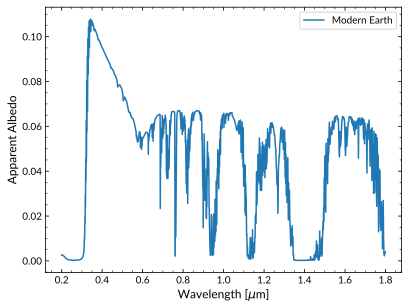

In [5]:
columns = ["WAVELENGTH", "ALBEDO"]
df_earth = pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)
datavis.plot_spectrum(df_earth, label="Modern Earth");

In [9]:
def test_instrument(config, instrument):
    datamod.set_instrument(config, instrument)
    result = psg.run(config)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)

In [10]:
config_SSUV = config.copy()
df_SSUV = test_instrument(config_SSUV, "SS-UV")

config_SSVis = config.copy()
df_SSVis = test_instrument(config_SSVis, "SS-Vis")

config_SSNIR = config.copy()
df_SSNIR = test_instrument(config_SSNIR, "SS-NIR")

df = pd.concat([df_SSUV, df_SSVis, df_SSNIR]).reset_index(drop=True)

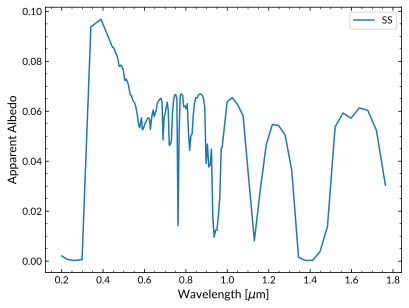

In [11]:
datavis.plot_spectrum(df, label="SS");

## Test 2 - Changing the abundances

In [12]:
def test_abundances(dictionary: dict, gas: str, multiplier: float) -> None:
    elements = ["CO2", "N2", "O2", "H2O", "CO", "C2H6", "HCN", "SO2", "O3", "CH4", "N2O", "NH3", "CH3Cl"]
    gas_index = elements.index(gas)
    for key, value in dictionary.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            gas_value = float(values[gas_index + 2])
            new_value = gas_value * multiplier       
            values[gas_index + 2] = str(new_value)
            dictionary[key] = ','.join(values)
    result = psg.run(dictionary)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)

<Axes: xlabel='Wavelength [$\\mu$m]', ylabel='Apparent Albedo'>

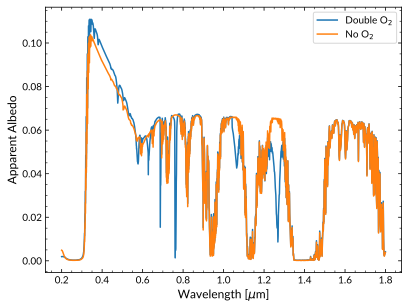

In [13]:
# Doubling the O2 concentration
config_double_O2 = config_HWC.copy()
df_double_O2 = test_abundances(config_double_O2, "O2", 2)

# Removing O2 from the atmosphere
config_zero_O2 = config_HWC.copy()
df_no_O2 = test_abundances(config_zero_O2, "O2", 0)

_, ax = plt.subplots()
datavis.plot_spectrum(df_double_O2, ax = ax, label="Double O${}_2$")
datavis.plot_spectrum(df_no_O2, ax = ax, label="No O${}_2$");

## Test 3 - Modifying atmospheric pressure (mbar)

In [14]:
def test_pressure(config, pressure):
    config["ATMOSPHERE-PRESSURE"] = str(pressure)
    result = psg.run(config)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

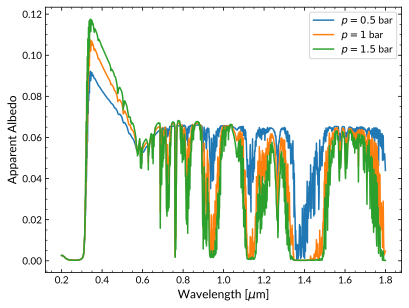

In [15]:
# 500 mbar = .5 bar
# The spectrum returned nothing for double and 4x the atmospheric pressure
config_half_atm = config_HWC.copy()
df_half_atm = test_pressure(config_half_atm, 500)

config_1_0_atm = config_HWC.copy()
df_1_0_atm = test_pressure(config_1_0_atm, 1000)

config_1_5_atm = config_HWC.copy()
df_1_5_atm = test_pressure(config_1_5_atm, 1500)

_, ax = plt.subplots()
datavis.plot_spectrum(df_half_atm, label="$p = 0.5$ bar", ax=ax)
datavis.plot_spectrum(df_1_0_atm, label="$p = 1$ bar", ax=ax)
datavis.plot_spectrum(df_1_5_atm, label="$p = 1.5$ bar", ax=ax);

When atmospheric pressure decreases, it generally indicates a more rarefied atmosphere. On the other hand, higher atmospheric pressure suggests a denser and more expansive atmosphere. The correlation between atmospheric density and the visibility of spectral signatures is intrinsically linked to photon-molecule interaction. In a dense atmosphere, the molecules present have more opportunities to interact with photons, resulting in more pronounced spectral signatures. However, when the atmosphere is more rarefied, these interactions decrease, leading to significant attenuation of spectral signatures.

## Generate a random model

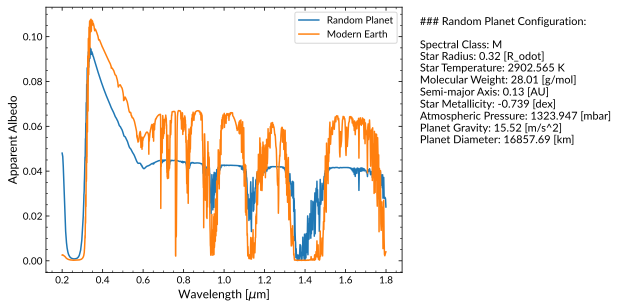

In [16]:
random_config = config_HWC.copy()
datamod.random_planet(random_config, geostages.molweight_modern())
result_random = psg.run(random_config)

columns = ["WAVELENGTH", "ALBEDO"]
df_rnd = pd.DataFrame(result_random["spectrum"][:, [0,1]], columns=columns)

SPECTRAL_CLASS = random_config['OBJECT-STAR-TYPE']
STAR_RADIUS = random_config['OBJECT-STAR-RADIUS']
STAR_TEMPERATURE = random_config['OBJECT-STAR-TEMPERATURE']
MOLECULAR_WEIGHT = round(random_config['ATMOSPHERE-WEIGHT'], 2)
SEMI_MAJOR_AXIS = round(random_config['OBJECT-STAR-DISTANCE'], 2)
STAR_METALLICITY = random_config['OBJECT-STAR-METALLICITY']
ATMOSPHERIC_PRESSURE = random_config["ATMOSPHERE-PRESSURE"]
PLANET_GRAVITY = round(random_config['OBJECT-GRAVITY'], 2)
PLANET_DIAMETER = round(random_config['OBJECT-DIAMETER'], 2)

_, ax = plt.subplots()
datavis.plot_spectrum(df_rnd, label="Random Planet", ax = ax)
datavis.plot_spectrum(df_earth, label="Modern Earth", ax = ax)

text = ("### Random Planet Configuration:\n\n"
        f"Spectral Class: {SPECTRAL_CLASS}\n"
        f"Star Radius: {STAR_RADIUS} [R_odot]\n"
        f"Star Temperature: {STAR_TEMPERATURE} K\n"
        f"Molecular Weight: {MOLECULAR_WEIGHT} [g/mol]\n"
        f"Semi-major Axis: {SEMI_MAJOR_AXIS} [AU]\n"
        f"Star Metallicity: {STAR_METALLICITY} [dex]\n"
        f"Atmospheric Pressure: {ATMOSPHERIC_PRESSURE} [mbar]\n"
        f"Planet Gravity: {PLANET_GRAVITY} [m/s^2]\n"       
        f"Planet Diameter: {PLANET_DIAMETER} [km]\n"
        )

plt.text(1.05, 0.7, text,
        horizontalalignment='left',
        verticalalignment='center',
        fontsize = 11, transform=plt.gca().transAxes);